# baseline v3

이 베이스라인 코드는 `사전학습 모델 로드`, `배치 학습`, `파인튜닝`, `양자화`, `PEFT` 등이 적용된 버전입니다.

Colab의 GPU 환경에서 개발되었습니다.
- 런타임 - 런타임 유형 변경 - GPU로 변경(T4 GPU 등)



# 환경 준비

개발 환경에 필요한 라이브러리 버전을 고정하고 최신 버전으로 라이브러리를 업데이트합니다.

- 아래 셀 실행
- 실행 완료 후 런타임 - 세션 다시 시작

In [ ]:
# !kaggle competitions download -c 2025-ssafy-14

In [1]:
%pip -q install "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" "bitsandbytes>=0.43.1" datasets pillow pandas torch torchvision --upgrade

Note: you may need to restart the kernel to use updated packages.


# 데이터 준비

개발에 필요한 데이터를 준비합니다.

- train.csv, train 폴더
- test.csv, test 폴더
- sample_submission.csv

본 베이스라인은 colab에서 구글 드라이브를 마운트하여 사용합니다.

데이터를 압축 해제하는데 몇 분 정도의 시간이 소요됩니다.

#### 실습 참고 내용

    챕터 2-2 합성 데이터 실습
    - 구글 드라이브 마운트 : drive()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Colab 내장 라이브러리를 이용해 kaggle.json 파일을 업로드합니다.
# from google.colab import files
# files.upload()

# # kaggle API가 인식할 수 있는 경로에 디렉토리를 만들고 파일을 이동시킵니다.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # 파일 권한을 설정합니다. (본인만 읽고 쓸 수 있도록)
# !chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# !kaggle competitions download -c 2025-ssafy-14

 99% 481M/485M [00:04<00:00, 145MB/s]
100% 485M/485M [00:04<00:00, 111MB/s]


In [ ]:
# # 압축 해제
# !unzip "2025-ssafy-14.zip" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/test/test_2776.jpg  
  inflating: /content/test/test_2777.jpg  
  inflating: /content/test/test_2778.jpg  
  inflating: /content/test/test_2779.jpg  
  inflating: /content/test/test_2780.jpg  
  inflating: /content/test/test_2781.jpg  
  inflating: /content/test/test_2782.jpg  
  inflating: /content/test/test_2783.jpg  
  inflating: /content/test/test_2784.jpg  
  inflating: /content/test/test_2785.jpg  
  inflating: /content/test/test_2786.jpg  
  inflating: /content/test/test_2787.jpg  
  inflating: /content/test/test_2788.jpg  
  inflating: /content/test/test_2789.jpg  
  inflating: /content/test/test_2790.jpg  
  inflating: /content/test/test_2791.jpg  
  inflating: /content/test/test_2792.jpg  
  inflating: /content/test/test_2793.jpg  
  inflating: /content/test/test_2794.jpg  
  inflating: /content/test/test_2795.jpg  
  inflating: /content/test/test_2796.jpg  
  inflating: /content/test/test_2797.jpg  
  inflating: /cont

# 라이브러리, 데이터, 설정

In [1]:
import os, re, math, random
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import torch
from typing import Dict, List, Any
from transformers import (
    AutoModelForImageTextToText,
    AutoProcessor,
    BitsAndBytesConfig,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm import tqdm

# 이미지 로드 시 픽셀 제한 해제
Image.MAX_IMAGE_PIXELS = None

# 디바이스 GPU 우선 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 사전 학습 모델 정의
MODEL_ID = "Qwen/Qwen3-VL-4B-Instruct"
IMAGE_SIZE = 384
MAX_NEW_TOKENS = 8
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# 데이터셋 로드
train_df = pd.read_csv("./train.csv")
#test_df  = pd.read_csv("/content/test.csv")

# 학습데이터 200개만 추출
train_df = train_df.sample(n=1000, random_state=SEED).reset_index(drop=True)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
print(train_df)
#print(test_df)

             id                  path                        question  \
0    train_1345  train/train_1345.jpg                    이 음식은 무엇인가요?   
1    train_3825  train/train_3825.jpg        이 음식의 주재료로 알맞은 것은 무엇인가요?   
2    train_3031  train/train_3031.jpg       사진 속 은박지에 싸여 있는 것은 무엇일까요?   
3    train_3619  train/train_3619.jpg     이 식사 구성에서 볼 수 없는 음식은 무엇인가요?   
4    train_1814  train/train_1814.jpg        이 사진에서 볼 수 있는 계절은 무엇인가요?   
..          ...                   ...                             ...   
995  train_2352  train/train_2352.jpg                 사진 속 음식은 무엇인가요?   
996  train_3689  train/train_3689.jpg      이 전시 공간에서 벽에 투사된 것은 무엇인가요?   
997  train_2497  train/train_2497.jpg     이 사진에서 볼 수 있는 꽃의 종류는 무엇인가요?   
998  train_3659  train/train_3659.jpg  이 한식 상차림에서 보이는 대표적인 반찬은 무엇인가요?   
999  train_1789  train/train_1789.jpg  이 사진에 있는 노란 바구니 안에는 무엇이 들어있나요?   

           a          b         c             d answer  
0    비빔밥과 김치  햄버거와 감자튀김  피자와 감자튀김       치킨과 떡볶이      d  
1       돼

# 모델, Processor

7.5GB 정도의 모델 다운로드가 진행됩니다. 10~20분 정도가 소요됩니다.

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - LoRA 구현 : LoraConfig()

In [ ]:
# 양자화
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# 프로세서
processor = AutoProcessor.from_pretrained(
    MODEL_ID,
    min_pixels=IMAGE_SIZE*IMAGE_SIZE,
    max_pixels=IMAGE_SIZE*IMAGE_SIZE,
    trust_remote_code=True,
)

# 사전학습 모델
base_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# 양자화 모델로 로드
base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()

# LoRA 세팅
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM",
)

# PEFT 모델 생성
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


trainable params: 16,515,072 || all params: 4,454,330,880 || trainable%: 0.3708


# 프롬프트 템플릿

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - 프롬프트 템플릿 : convert_to_chatml(), formatting_prompts_func()

In [4]:
# 모델 지시사항
SYSTEM_INSTRUCT = (
    "You are a helpful visual question answering assistant. "
    "Answer using exactly one letter among a, b, c, or d. No explanation."
)

# 프롬프트
def build_mc_prompt(question, a, b, c, d):
    return (
        f"{question}\n"
        f"(a) {a}\n(b) {b}\n(c) {c}\n(d) {d}\n\n"
        "정답을 반드시 a, b, c, d 중 하나의 소문자 한 글자로만 출력하세요."
    )

# Custom Dataset, Collator

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - TensorDataset()

    챕터 5-2 데이터 생성 및 파인튜닝 (향후 학습 분량)
    - IntentDataset()

In [5]:
# 커스텀 데이터셋
class VQAMCDataset(Dataset):
    def __init__(self, df, processor, train=True):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.train = train

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["path"]).convert("RGB")

        q = str(row["question"])
        a, b, c, d = str(row["a"]), str(row["b"]), str(row["c"]), str(row["d"])
        user_text = build_mc_prompt(q, a, b, c, d)

        messages = [
            {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
            {"role":"user","content":[
                {"type":"image","image":img},
                {"type":"text","text":user_text}
            ]}
        ]
        if self.train:
            gold = str(row["answer"]).strip().lower()
            messages.append({"role":"assistant","content":[{"type":"text","text":gold}]})

        return {"messages": messages, "image": img}

# 데이터 콜레이터
@dataclass
class DataCollator:
    processor: Any
    train: bool = True

    def __call__(self, batch):
        texts, images = [], []
        for sample in batch:
            messages = sample["messages"]
            img = sample["image"]

            text = self.processor.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            )
            texts.append(text)
            images.append(img)

        enc = self.processor(
            text=texts,
            images=images,
            padding=True,
            return_tensors="pt"
        )

        if self.train:
            enc["labels"] = enc["input_ids"].clone()

        return enc


# DataLoader

#### 실습 참고 내용

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 데이터로더 정의 : DataLoader()

In [7]:
# 검증용 데이터 분리
split = int(len(train_df)*0.9)
valid_split = int(len(train_df)*0.5)
train_subset, valid_subset = train_df.iloc[:split], train_df.iloc[split:]
valid_subset, test_subset = valid_subset.iloc[:valid_split], valid_subset.iloc[valid_split:]
# VQAMCDataset 형태로 변환
train_ds = VQAMCDataset(train_subset, processor, train=True)
valid_ds = VQAMCDataset(valid_subset, processor, train=True)

# 데이터로더
# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=DataCollator(processor, True), num_workers=0)
# valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=DataCollator(processor, True), num_workers=0)

print(f"Train samples: {len(train_ds)}, Valid samples: {len(valid_ds)}")

Train samples: 900, Valid samples: 100


# fine-tuning

- 200개만 학습 : 10~20분 소요

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - 모델 정의 : SimpleMLP(), SequentialMLP()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset
from dataclasses import dataclass
from typing import Any
from PIL import Image
import torch
#하이퍼 파라미터 설정
EPOCHS = 2
LEARNING_RATE = 2e-4
GRADIENT_ACCUMULATION_STEPS = 4
WARMUP_RATIO = 0.03
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01

# --- 환경 및 경로 설정 ---
# Mixed Precision에 사용할 데이터 타입 (사용하지 않으려면 None)
DTYPE = torch.bfloat16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "./qwen3_vl_4b_lora"


training_args = TrainingArguments(
    output_dir=SAVE_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim="adamzw_torch",
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    lr_scheduler_type="linear",
    warmup_ratio=WARMUP_RATIO,
    logging_steps=10,  # 10 스텝마다 로그 출력
    eval_on_start=False,
    save_strategy="epoch",  # 한 에포크마다 모델 저장
    eval_strategy="steps", # 10 스텝마다 검증
    eval_steps=10,
    bf16=True if DTYPE == torch.bfloat16 else False, # bfloat16 사용
    report_to="none", # wandb, tensorboard 등 로깅 도구
    remove_unused_columns=False, # 커스텀 데이터셋 사용시 중요

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# --- 5. Trainer 객체 생성 ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=DataCollator(processor), # 직접 만든 콜레이터 전달
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [9]:
# --- 6. 학습 시작! ---
trainer.train()

/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
10,11.175400,7.624982
20,6.092300,4.977641
30,4.591400,4.337727
40,4.222700,4.159998
50,4.203200,4.121287


TrainOutput(global_step=57, training_loss=5.810707694605777, metrics={'train_runtime': 3247.8684, 'train_samples_per_second': 0.277, 'train_steps_per_second': 0.018, 'total_flos': 5968147104251904.0, 'train_loss': 5.810707694605777, 'epoch': 1.0})

[{'loss': 11.1754, 'grad_norm': 10.101815223693848, 'learning_rate': 8.727272727272727e-05, 'epoch': 0.17699115044247787, 'step': 10}, {'eval_loss': 7.624981880187988, 'eval_runtime': 223.1733, 'eval_samples_per_second': 0.448, 'eval_steps_per_second': 0.058, 'epoch': 0.17699115044247787, 'step': 10}, {'loss': 6.0923, 'grad_norm': 2.0147016048431396, 'learning_rate': 6.90909090909091e-05, 'epoch': 0.35398230088495575, 'step': 20}, {'eval_loss': 4.9776411056518555, 'eval_runtime': 221.7485, 'eval_samples_per_second': 0.451, 'eval_steps_per_second': 0.059, 'epoch': 0.35398230088495575, 'step': 20}, {'loss': 4.5914, 'grad_norm': 1.102459192276001, 'learning_rate': 5.090909090909091e-05, 'epoch': 0.5309734513274337, 'step': 30}, {'eval_loss': 4.337727069854736, 'eval_runtime': 221.8716, 'eval_samples_per_second': 0.451, 'eval_steps_per_second': 0.059, 'epoch': 0.5309734513274337, 'step': 30}, {'loss': 4.2227, 'grad_norm': 0.54778653383255, 'learning_rate': 3.272727272727273e-05, 'epoch': 0

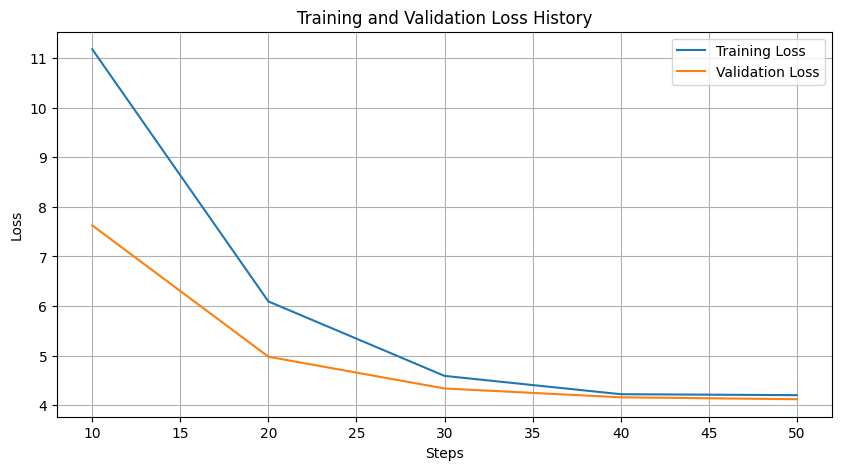

In [12]:
# 학습이 완료된 후, .state.log_history에서 기록을 가져옵니다.
history = trainer.state.log_history
print(history)

# --- 7. (선택) 기록을 DataFrame으로 변환하여 시각화 ---
import pandas as pd
import matplotlib.pyplot as plt

# 리스트 형태의 로그를 pandas DataFrame으로 변환하면 다루기 쉽습니다.
df = pd.DataFrame(history)

# train loss와 eval loss 분리
train_loss_df = df[df['loss'].notna()].copy()
eval_loss_df = df[df['eval_loss'].notna()].copy()

# step을 정수형으로 변환 (필요시)
train_loss_df['step'] = train_loss_df['step'].astype(int)
eval_loss_df['step'] = eval_loss_df['step'].astype(int)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss')
plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# import torch
# import math
# from transformers import get_linear_schedule_with_warmup
# from tqdm.auto import tqdm

# # --- 학습 환경 초기화 ---
# model = model.to(DEVICE)

# # 옵티마이저 및 스케줄러 설정
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# num_training_steps = EPOCHS * math.ceil(len(train_loader) / GRADIENT_ACCUMULATION_STEPS)
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(num_training_steps * WARMUP_RATIO),
#     num_training_steps=num_training_steps
# )

# # Mixed Precision 스케일러
# scaler = torch.cuda.amp.GradScaler(enabled=(DTYPE is not None))

# # --- 학습 루프 시작 ---
# # --- 학습 루프 시작 ---
# global_step = 0
# latest_val_loss = float("inf")
# for epoch in range(EPOCHS):
#     model.train()
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

#     for step, batch in enumerate(progress_bar):
#         batch = {k: v.to(DEVICE) for k, v in batch.items()}

#         # --- 그래디언트 계산 ---
#         with torch.cuda.amp.autocast(dtype=DTYPE):
#             outputs = model(**batch)
#             loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS

#         scaler.scale(loss).backward()

#         # --- 정해진 스텝마다 파라미터 업데이트 ---
#         if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
#             # 옵티마이저 스텝
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad(set_to_none=True)
#             scheduler.step()
#             global_step += 1

#             # --- 주기적인 검증 ---
#             if global_step > 0 and global_step % 10 == 0:
#                 model.eval()
#                 val_loss = 0.0
#                 with torch.no_grad(), torch.cuda.amp.autocast(dtype=DTYPE):
#                     for vb in valid_loader:
#                         vb = {k: v.to(DEVICE) for k, v in vb.items()}
#                         val_loss += model(**vb).loss.item()

#                 latest_val_loss = val_loss / len(valid_loader)
#                 model.train() # 다시 학습 모드로 전환

#             # 진행률 표시줄 업데이트 (loss는 근사치)
#             progress_bar.set_postfix({
#                 "train_loss": f"{loss.item() * GRADIENT_ACCUMULATION_STEPS:.3f}",
#                 "val_loss": f"{latest_val_loss:.3f}"
#             })

# # (에포크의 마지막에 남은 그래디언트 처리 - 선택 사항이지만 권장)
# if len(train_loader) % GRADIENT_ACCUMULATION_STEPS != 0:
#     scaler.step(optimizer)
#     scaler.update()
#     optimizer.zero_grad(set_to_none=True)
#     scheduler.step()
#     global_step += 1

# # --- 모델 저장 ---
# model.save_pretrained(SAVE_DIR)
# processor.save_pretrained(SAVE_DIR)
# print(f"✅ Saved model and processor to: {SAVE_DIR}")

# inference

30분~1시간 소요

#### 실습 참고 내용

    챕터4-1 RAG 기반 Customer Service AI 에이전트 개발
    - 데이터 파서 : langchain_core.output_parsers(), StrOutputParser()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

In [16]:
print (valid_subset)

             id                  path                               question  \
900  train_3024  train/train_3024.jpg    이 약국 입구에 설치된 배너가 주로 광고하는 제품은 무엇인가요?   
901  train_1433  train/train_1433.jpg           이 사진에서 보이는 음식 중 빙수는 어느 것인가요?   
902  train_1393  train/train_1393.jpg  이 사진에서 볼 수 있는 가게 간판에 적힌 음식 종류는 무엇인가요?   
903  train_3167  train/train_3167.jpg                      이 사진 속 동물은 무엇인가요?   
904  train_0026  train/train_0026.jpg         이 사진에서 주로 볼 수 있는 자연 현상은 무엇인가요?   
..          ...                   ...                                    ...   
995  train_2352  train/train_2352.jpg                        사진 속 음식은 무엇인가요?   
996  train_3689  train/train_3689.jpg             이 전시 공간에서 벽에 투사된 것은 무엇인가요?   
997  train_2497  train/train_2497.jpg            이 사진에서 볼 수 있는 꽃의 종류는 무엇인가요?   
998  train_3659  train/train_3659.jpg         이 한식 상차림에서 보이는 대표적인 반찬은 무엇인가요?   
999  train_1789  train/train_1789.jpg         이 사진에 있는 노란 바구니 안에는 무엇이 들어있나요?   

                    a                 b

# Valid_Test Sample로 테스트

Inference: 100%|██████████| 100/100 [00:20<00:00,  4.91sample/s]

✅ Accuracy: 86.00%


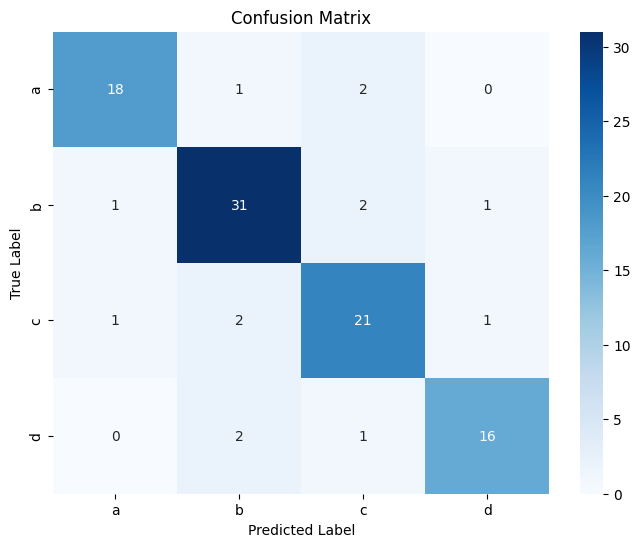

              precision    recall  f1-score   support

           a       0.90      0.86      0.88        21
           b       0.86      0.89      0.87        35
           c       0.81      0.84      0.82        25
           d       0.89      0.84      0.86        19

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [20]:
# 데이터 파서 : 모델의 응답에서 선지를 추출
from sklearn.metrics import accuracy_score # 정확도 계산을 위해 import
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def extract_choice(text: str) -> str:
    text = text.strip().lower()

    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if not lines:
        return "a"
    last = lines[-1]
    if last in ["a", "b", "c", "d"]:
        return last

    tokens = last.split()
    for tok in tokens:
        if tok in ["a", "b", "c", "d"]:
            return tok
    return "a"
# 추론을 위해 모든 레이어 활성화
model.eval()
preds = []
labels = [] # 정답을 저장할 리스트

# 추론 루프
for i in tqdm(range(len(valid_subset)), desc="Inference", unit="sample"):
    row = valid_subset.iloc[i]
    img = Image.open(row["path"]).convert("RGB")
    user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])
    label = row["answer"]
    labels.append(label)

    messages = [
        {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
        {"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":user_text}
        ]}
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=2, do_sample=False,
                                 eos_token_id=processor.tokenizer.eos_token_id)

    # 새로 생성된 부분만 디코딩 (더 안정적인 방법)
    input_len = inputs['input_ids'].shape[1]
    generated_ids = out_ids[:, input_len:]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    preds.append(extract_choice(output_text))

# --- ✅ 정확도 측정 코드 추가 ---
accuracy = accuracy_score(labels, preds)
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
# -----------------------------
class_names = ['a', 'b', 'c', 'd'] 
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


report = classification_report(labels, preds, target_names=class_names)
print(report)

In [ ]:
# # 모델 응답 예시
# for txt in preds:
#     print(txt)

c
d
a
b
a
c
b
b
b
b
b
d
c
a
c
b
c
b
b
b
a
a
b
d
c
a
c
a
b
a
d
c
b
a
b
b
d
c
b
d
a
b
c
a
c
b
c
b
d
d
b
b
d
b
a
c
c
d
b
b
c
b
a
c
d
a
c
c
c
b
d
d
d
c
b
b
a
a
b
a
b
c
b
c
c
d
a
c
d
c
b
d
a
b
a
b
d
b
c
b


# 실제 test data Inference

In [23]:
test_df  = pd.read_csv("./test.csv")
print(test_df)

             id                path                        question  \
0     test_0001  test/test_0001.jpg             이 사진에 보이는 탑은 무엇인가요?   
1     test_0002  test/test_0002.jpg  이 사진에서 볼 수 있는 나무의 잎 색깔은 무엇인가요?   
2     test_0003  test/test_0003.jpg            이 사진에 보이는 건물은 무엇인가요?   
3     test_0004  test/test_0004.jpg      이 사진에서 보이는 신호등의 상태는 무엇인가요?   
4     test_0005  test/test_0005.jpg   사진 속 의자 위에 놓여 있지 않은 것은 무엇인가요?   
...         ...                 ...                             ...   
3882  test_3883  test/test_3883.jpg        이 사진에서 보이는 길의 특징은 무엇인가요?   
3883  test_3884  test/test_3884.jpg             이 사진에 보이는 탑은 무엇인가요?   
3884  test_3885  test/test_3885.jpg    사진 속 테이블 위에 놓여 있는 음료는 무엇인가요?   
3885  test_3886  test/test_3886.jpg    이 이미지에서 보이는 음식이 아닌 것은 무엇인가요?   
3886  test_3887  test/test_3887.jpg             이 사진의 주요 상황은 무엇인가요?   

                   a            b           c               d  
0               63빌딩         남산타워        롯데타워            한강대교  
1                초록

In [24]:
# 추론을 위해 모든 레이어 활성화
model.eval()
preds = []

# 추론 루프
for i in tqdm(range(len(test_df)), desc="Inference", unit="sample"):
    row = test_df.iloc[i]
    img = Image.open(row["path"]).convert("RGB")
    user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])

    messages = [
        {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
        {"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":user_text}
        ]}
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=2, do_sample=False,
                                 eos_token_id=processor.tokenizer.eos_token_id)
    output_text = processor.batch_decode(out_ids, skip_special_tokens=True)[0]
    # print("output_text:", output_text)
    # print("extract_choice:", extract_choice(output_text))
    preds.append(extract_choice(output_text))

Inference: 100%|██████████| 3887/3887 [14:14<00:00,  4.55sample/s]


In [25]:
# 제출 파일 생성
submission = pd.DataFrame({"id": test_df["id"], "answer": preds})
submission.to_csv("./submission.csv", index=False)
print("Saved ./submission.csv")

Saved ./submission.csv
